<a href="https://colab.research.google.com/github/CwickHolmesalot/PowerDensity_AAPG2024/blob/main/AAPG03_FeatureSelection_FieldScale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rethinking Power Density for Geothermal Resource Estimation<br>
## Script 3: feature selection for field-scale predictive modeling<br>
Author: Chad Holmes<br>
Date: December 2024

### load libraries

In [ ]:
# load libraries
import pandas as pd
import numpy as np
import pickle as pkl
import time
import gc
import math
from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

### mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### load data

In [ ]:
path = r'drive/MyDrive/Colab Notebooks/PowerDensity/Papers/AAPG'
dirpath = Path(path)

In [ ]:
# define file locations
datafile = r'gdf_complete_FIELDS.xlsx'
pklfile  = r'gdf_complete_FIELDS.pkl'

In [ ]:
# load data
with open(dirpath / 'Output' / pklfile, 'rb') as f:
    origdf, datadf, encoders = pkl.load(f)

# datadf.columns
datadf.shape

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OrdinalEncoder from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


(100, 73)

#### build correlation matrix

<Axes: >

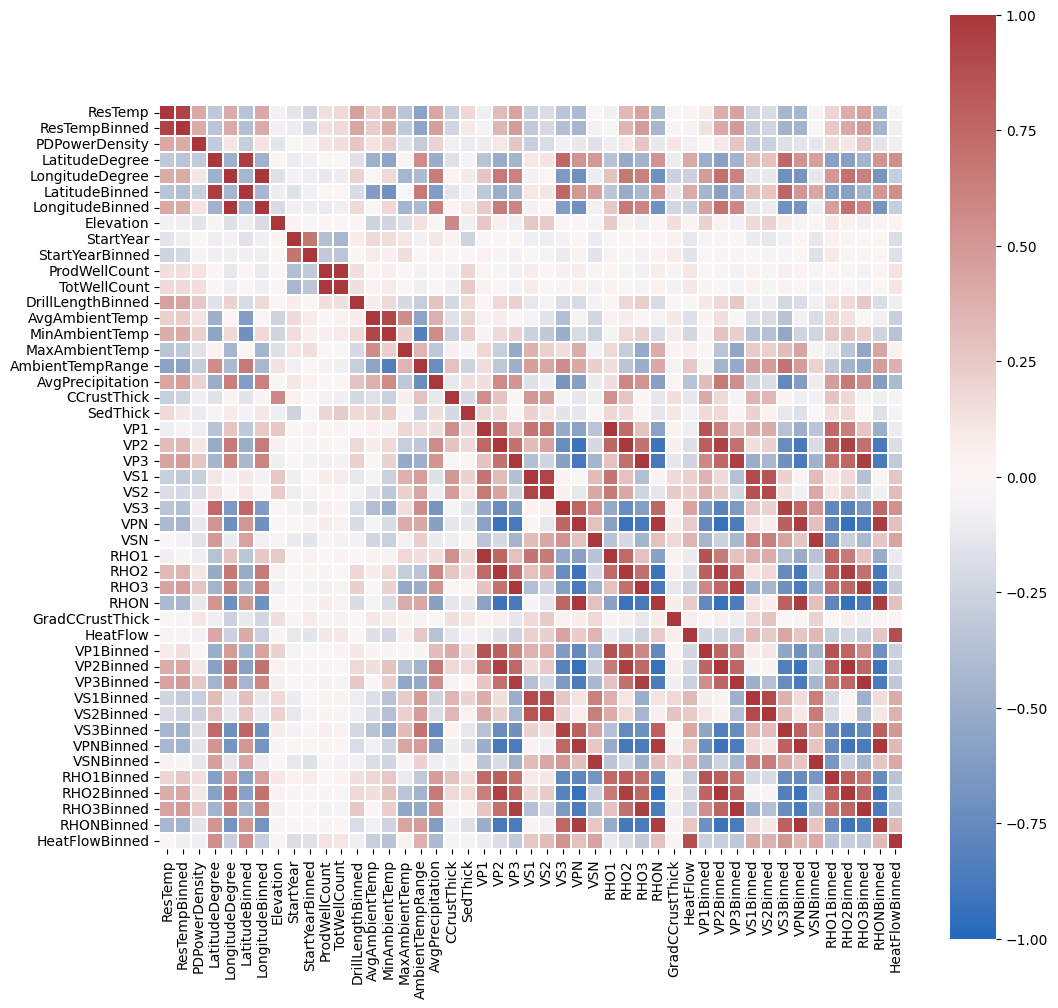

In [ ]:
dropcols=['NameplateCapacity',   # approx. part of power density, which is being predicted
          'PowerPerWell',        # also drop as this gets close to the predicted value (PD)
          'PDTemp',              # duplicate of ResTemp (WS version)
          'PDTemp_Edited']       # duplicate of ResTemp (intentional duplicate)

numcols = datadf.drop(dropcols,axis=1).select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = datadf[numcols].corr()
plt.rcdefaults()
graphWidth = 1200
graphHeight = 1200
f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
sns.heatmap(correlation_matrix,
            vmin=-1,
            vmax=1,
            square=True,
            cmap="vlag",#YlGnBu",
            linewidths=0.1,
            annot=False, #True,
            fmt='.1f',
            annot_kws={"fontsize":6})

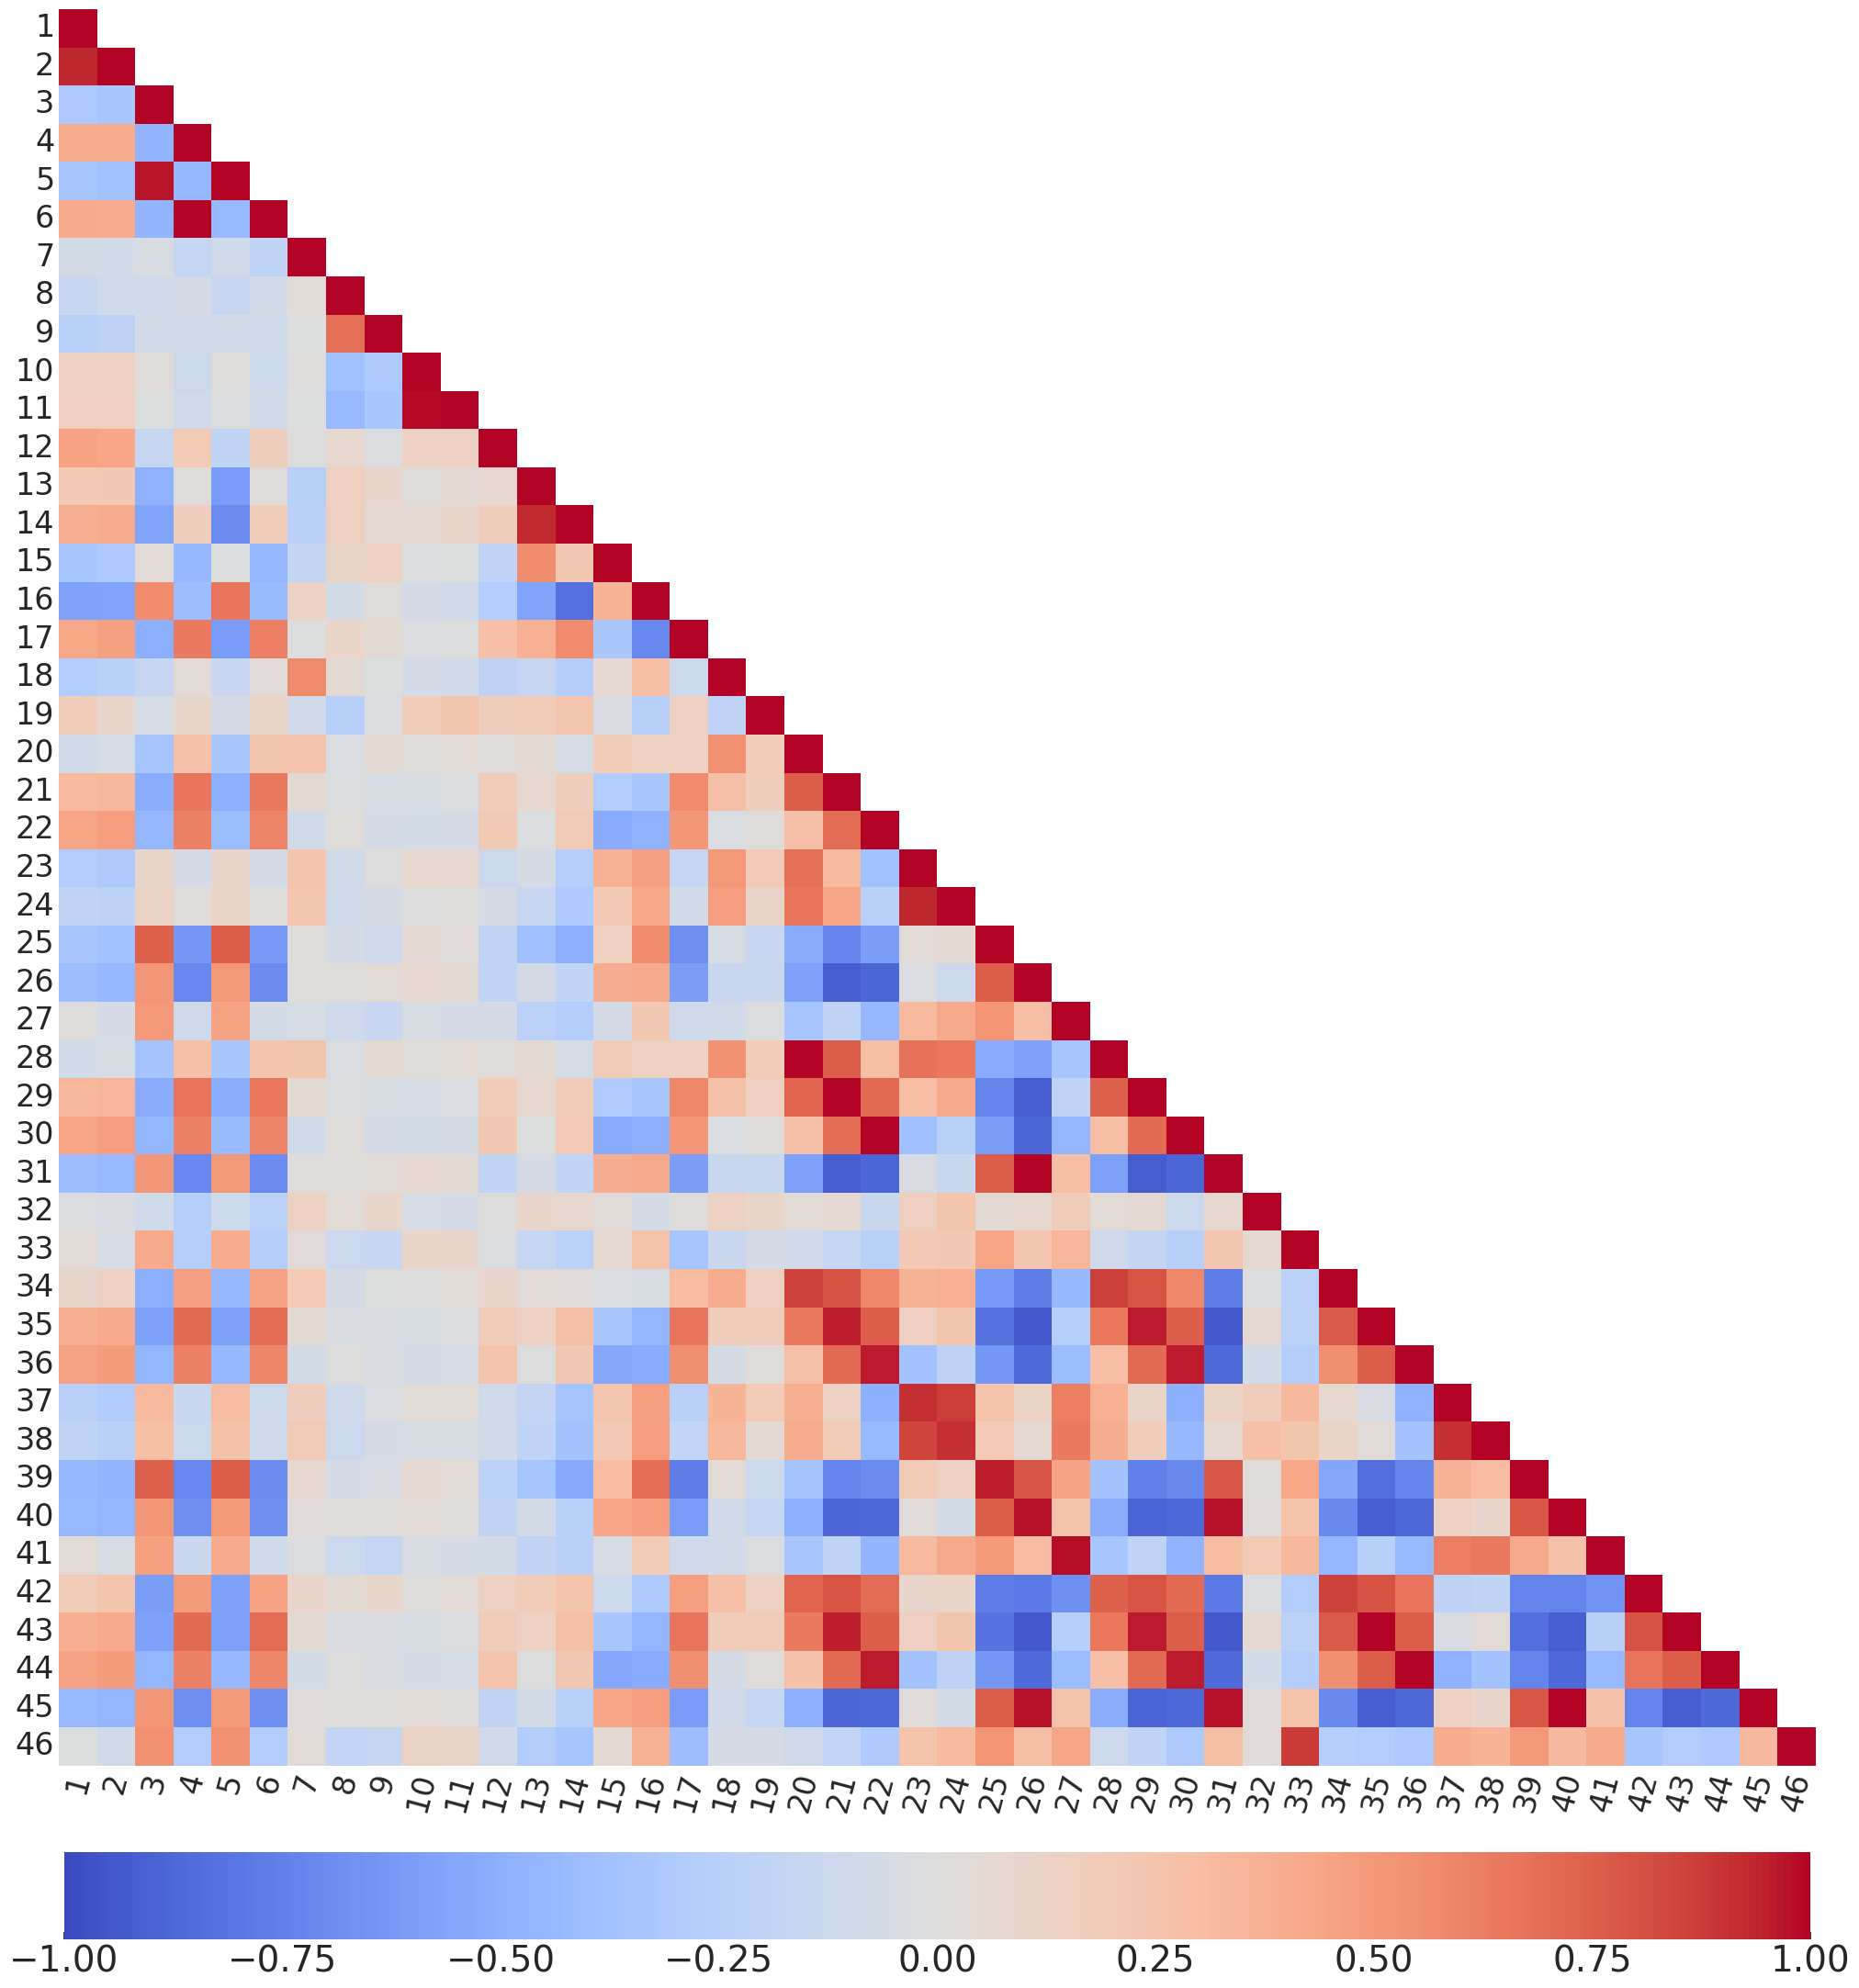

In [ ]:
# create a lower half correlation matrix with highlighting focused on high correlation values
corr = datadf[numcols].drop(['PDPowerDensity'],axis=1).corr(method='pearson')
colnames = datadf[numcols].drop(['PDPowerDensity'],axis=1).columns
num_labels = [str(n) for n in np.arange(1, len(colnames)+1)]
df_len = len(corr.columns)
fontsz=24

fig, ax=plt.subplots(figsize=(df_len/1.5,df_len/1.5))
sns.set(font_scale=1.0)
sns.set_style("ticks",{'xtick.direction':'in',
                       'ytick.direction':'in',
                       'xtick.top': False,
                       'ytick.right': False})
mask = np.triu(np.ones_like(corr, dtype=bool),k=1)
cmap = plt.get_cmap('coolwarm')
# cmap = LinearSegmentedColormap.from_list('custom', [(0, 'blue'), (0.2, 'white'), (0.8, 'white'), (1, 'red')],N=256)

sns.heatmap(corr,
            mask=mask,
            cbar_kws={"shrink": .8, "orientation": "horizontal", "location": "bottom", "pad": .04},
            annot=False,
            fmt='.1f',
            cmap=cmap,
            cbar=True,
            ax=ax, square=True,
            vmin=-1, vmax=1,
            xticklabels=num_labels,  # Use numerical labels for x-axis
            yticklabels=num_labels)  # Use numerical labels for y-axis

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=fontsz+4)

ax.set_xlim(0, df_len)
ax.set_ylim(df_len, 0)
plt.xticks(rotation=75, fontsize=fontsz)
plt.yticks(rotation=0, fontsize=fontsz)
plt.show()

outfile = str('Fig4A-Scaled_Correlation_Matrix.png')
fig.savefig(dirpath / 'Figures' / outfile, dpi=400)

In [ ]:
# drop highly-correlated variables
dropcols = ['NameplateCapacity',   # approx. part of power density, which is being predicted
            'PowerPerWell',        # also drop as this gets close to the predicted value (PD)
            'PDTemp',              # duplicate of ResTemp (WS version)
            'PDTemp_Edited',       # duplicate of ResTemp (intentional duplicate)
            'ResTempBinned',       # keeping binned version
            'Country',             # sparse dataset, geography captured by lat/lon and region
            'LatitudeDegree',      # binned values replace this due to sparsity
            'LongitudeDegree',     # binned values replace this due to sparsity
            'TotWellCount',        # scales with production well count, keeping production wells
            'Elevation',           # colinear with crustal thickness
            'StartYear',           # keeping binned version
            'MinAmbientTemp',      # highly correlated with Avg Temp
            'AvgPrecipitation',    # highly colinear with Avg Temp
            'RHO1',                # perfect colinearity with VP1
            'RHO2',                # perfect colinearity with VP2
            'RHO3',                # perfect colinearity with VP3
            'RHON',                # perfect colinearity with VPN
            'VP2',                 # highly colinear with VP1 and LongitudeBinned
            'VS2',                 # highly colinear with VS1
            'VS3',                 # highly colinear with VP2 and LatitudeBinned
            'VPN',                 # highly colinear with VP2 and VP3
            'VSN',                 # highly colinear with Region
            'RHO1Binned',          # perfect colinearity with VP1
            'RHO2Binned',          # perfect colinearity with VP2
            'RHO3Binned',          # perfect colinearity with VP3
            'RHONBinned',          # perfect colinearity with VPN
            'VP1Binned',           # dropping binned data from ECM1 model - value ranges are small
            'VP2Binned',
            'VP3Binned',
            'VPNBinned',
            'VS1Binned',
            'VS2Binned',
            'VS3Binned',
            'VSNBinned',
            'HeatFlowBinned']      # more colinear with LatitudeBinned than raw heat flow

numcols = datadf.drop(dropcols,axis=1).select_dtypes(include=['int64', 'float64']).columns
numcols = [n for n in numcols if n not in dropcols]

### check how the updated feature list looks via correlation matrices

<Axes: >

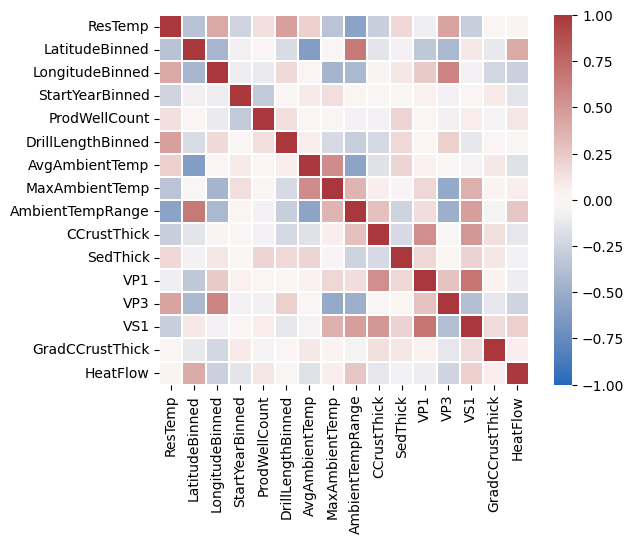

In [ ]:
correlation_matrix = datadf[numcols].drop(['PDPowerDensity'],axis=1).corr()
plt.rcdefaults()
sns.heatmap(correlation_matrix,
            vmin=-1,
            vmax=1,
            square=True,
            cmap="vlag",
            linewidths=0.1,
            annot=False,
            fmt='.1f',
            annot_kws={"fontsize":6})

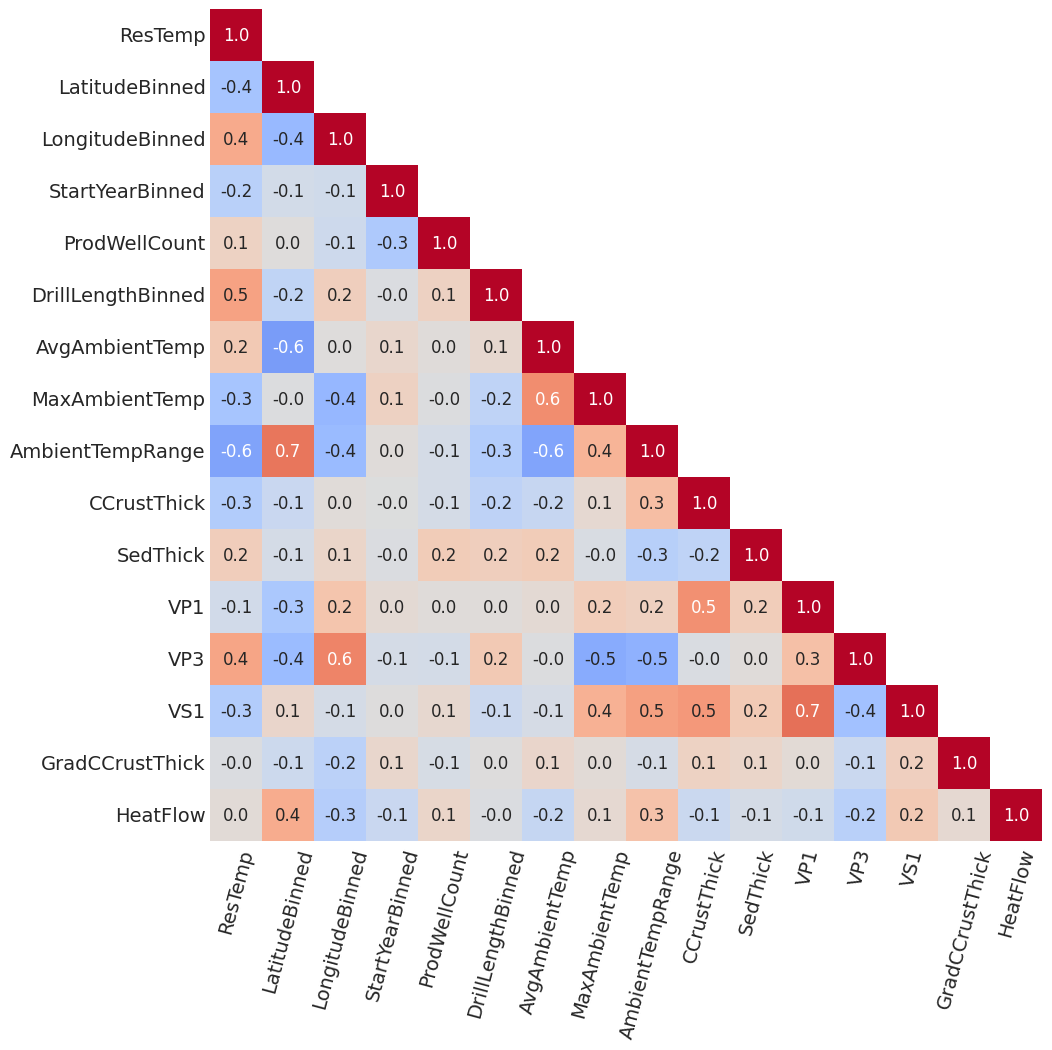

In [ ]:
corr = datadf[numcols].drop(['PDPowerDensity'],axis=1).corr(method='pearson')
corr.columns = datadf[numcols].drop(['PDPowerDensity'],axis=1).columns
df_len = len(corr.columns)
fontsz=16

fig, ax=plt.subplots(figsize=(df_len/1.5,df_len/1.5))
sns.set(font_scale=1.0)
sns.set_style("ticks",{'xtick.direction': 'in',
                       'ytick.direction':'in',
                       'xtick.top': False,'ytick.right': False})
mask = np.triu(np.ones_like(corr, dtype=bool),k=1)
cmap = plt.get_cmap('coolwarm')
# cmap = LinearSegmentedColormap.from_list('custom', [(0, 'blue'), (0.2, 'white'), (0.8, 'white'), (1, 'red')],N=256)

sns.heatmap(corr, mask = mask, cbar_kws={"shrink": .2}, annot=True, fmt='.1f',
            cmap=cmap, cbar=False, ax=ax, square=True, vmin=-1, vmax=1)
ax.set_xlim(0, df_len)
ax.set_ylim(df_len, 0)
plt.xticks(rotation=75, fontsize=fontsz-2)
plt.yticks(rotation=0, fontsize=fontsz-2)
fig.tight_layout()
plt.show()

outfile = str('Fig4B-Scaled_Correlation_Matrix.png')
fig.savefig(dirpath / 'Figures' / outfile, dpi=400)

### check mutual information

[('ResTemp', 0), ('LatitudeBinned', 0), ('LongitudeBinned', 0), ('StartYearBinned', 0), ('ProdWellCount', 0), ('DrillLengthBinned', 0), ('AvgAmbientTemp', 0), ('MaxAmbientTemp', 0), ('AmbientTempRange', 0), ('CCrustThick', 0), ('SedThick', 0), ('VP1', 0), ('VP3', 0), ('VS1', 0), ('GradCCrustThick', 0), ('HeatFlow', 0), ('Africa', 0), ('Central America', 0), ('East Asia', 0), ('Eurasia', 0), ('Europe', 0), ('North America', 0), ('North Asia', 0), ('Oceania', 0), ('Southeast Asia', 0), ('Arcs', 0), ('Fault-Based', 0), ('Other', 0), ('Rifts', 0), ('CARC', 0), ('COAR', 0), ('EXCT', 0), ('IARC', 0), ('LIPS', 0), ('ORON', 0), ('SOCE', 0)]
Index(['ResTemp', 'LatitudeBinned', 'LongitudeBinned', 'StartYearBinned',
       'ProdWellCount', 'DrillLengthBinned', 'AvgAmbientTemp',
       'MaxAmbientTemp', 'AmbientTempRange', 'CCrustThick', 'SedThick', 'VP1',
       'VP3', 'VS1', 'GradCCrustThick', 'HeatFlow', 'Africa',
       'Central America', 'East Asia', 'Eurasia', 'Europe', 'North America',
    

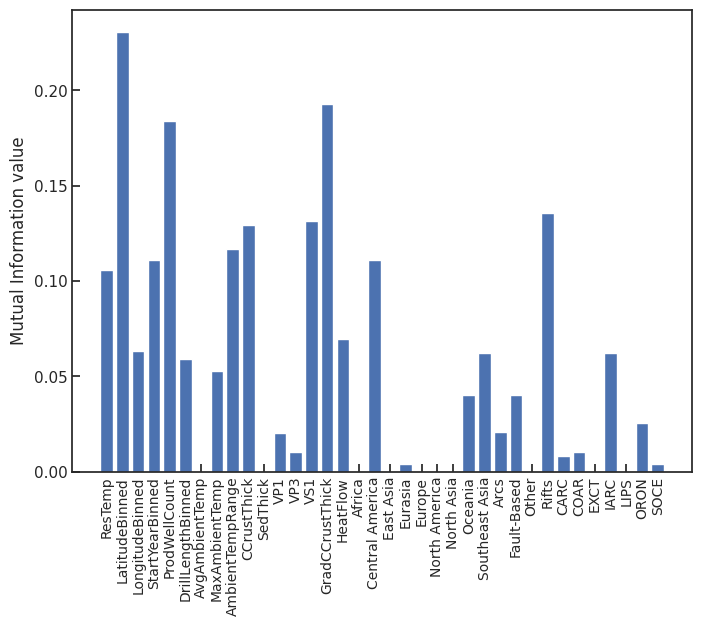

In [ ]:
# https://machinelearningmastery.com/feature-selection-for-regression-data/

xtradropcols = ['Name','PDPowerDensity'] #'PlantType','TectonicSetting','CrustType']
dropcols = list(set(dropcols + xtradropcols))

target   = datadf['PDPowerDensity'].apply(lambda x: np.log(x)) # predict the log of PD
keepcols = datadf.drop(dropcols,axis=1).columns

# check if there are any NaNs
print([(c,datadf[c].isna().sum()) for c in keepcols])

# feature selection
def select_features(X_train, y_train, X_test):
  # configure to select all features
  fs = SelectKBest(score_func=mutual_info_regression, k='all')

  # learn relationship from training data
  fs.fit(X_train, y_train)

  # transform train input data
  X_train_fs = fs.transform(X_train)

  # transform test input data
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(datadf.drop(dropcols,axis=1),
                                                    target,
                                                    test_size=0.2,
                                                    random_state=46)

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
selected_features = fs.get_support(indices=True)
feature_names = datadf.drop(dropcols,axis=1).columns[selected_features]
print(feature_names)

# what are scores for the features
for i in range(len(fs.scores_)):
  print('Feature %d: %f' % (i, fs.scores_[i]))

# plot the scores
plt.figure(figsize=(8,6))
plt.bar(feature_names, fs.scores_)
plt.ylabel('Mutual Information value')
plt.xticks(rotation=90, ha='center',fontsize=10)
plt.show()

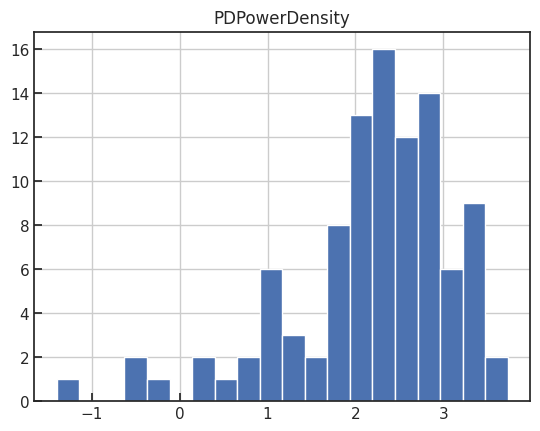

<ipython-input-13-68285fefb3a7>:5: RuntimeWarning: invalid value encountered in log
  datadf[c].apply(lambda x: np.log(x)).hist(bins=20)


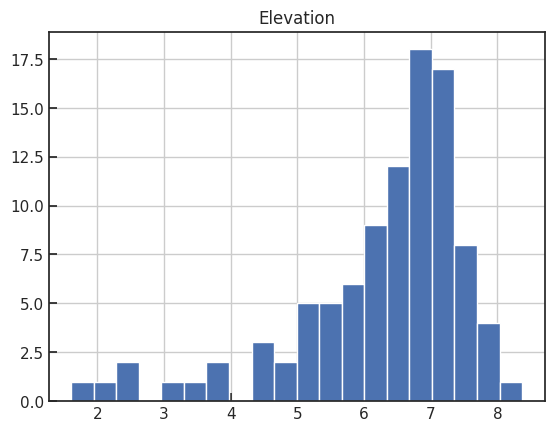

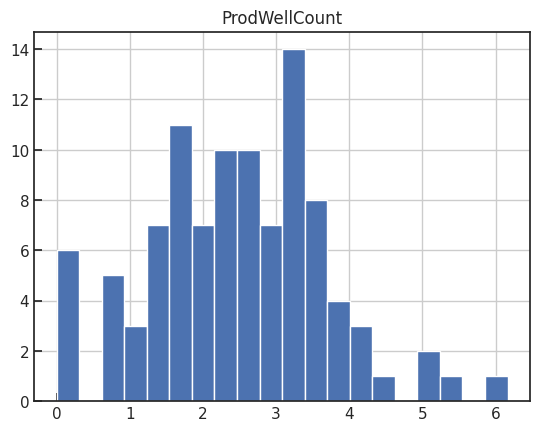

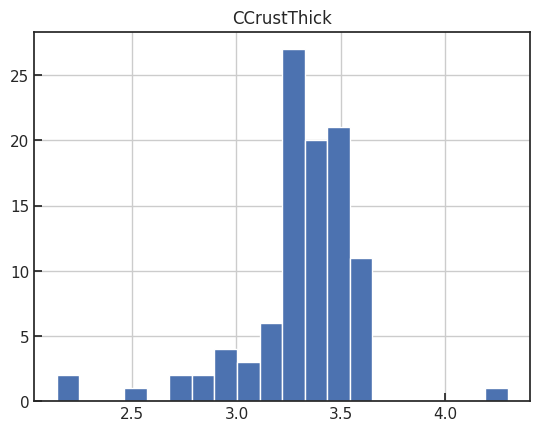

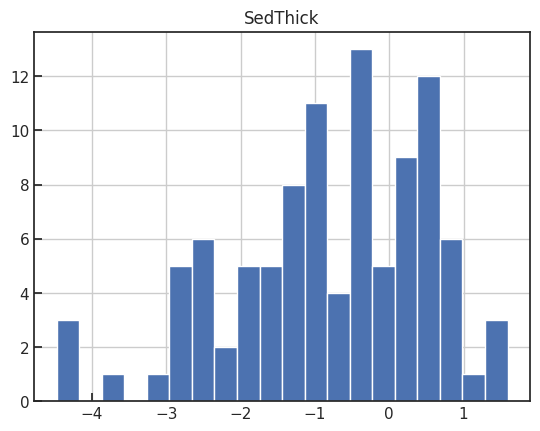

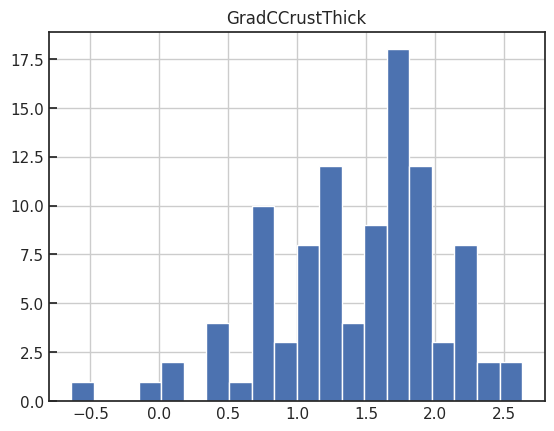

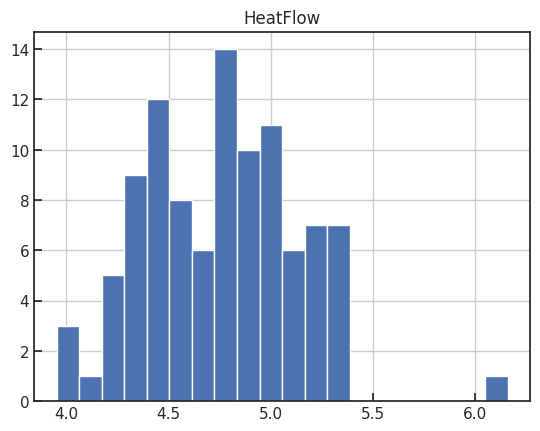

In [ ]:
# look for log normality by plotting distributions of log(variables)
lncols = ['PDPowerDensity', 'Elevation', 'ProdWellCount', 'CCrustThick', 'SedThick', 'GradCCrustThick', 'HeatFlow']

for c in lncols:
  # print(datadf[c].describe(include='all'))
  minval = datadf[c].min()
  if(minval < 0):
    datadf[c].apply(lambda x: np.log(x+minval+1e6)).hist(bins=20)
  else:
    datadf[c].apply(lambda x: np.log(x)).hist(bins=20)
  plt.title(c)
  plt.show()

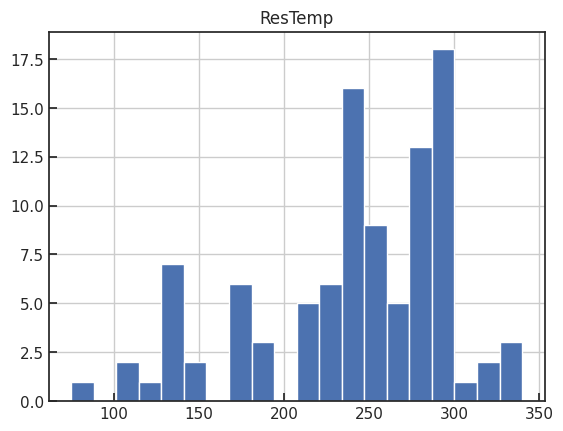

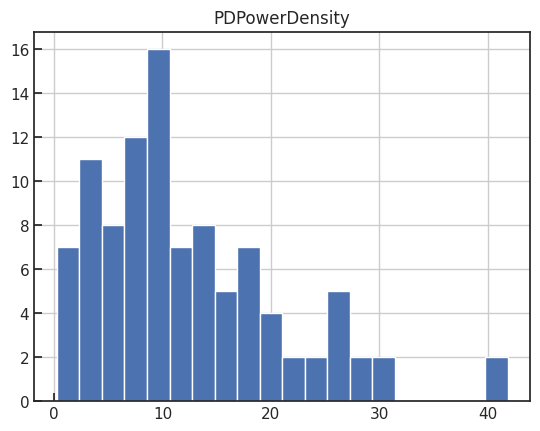

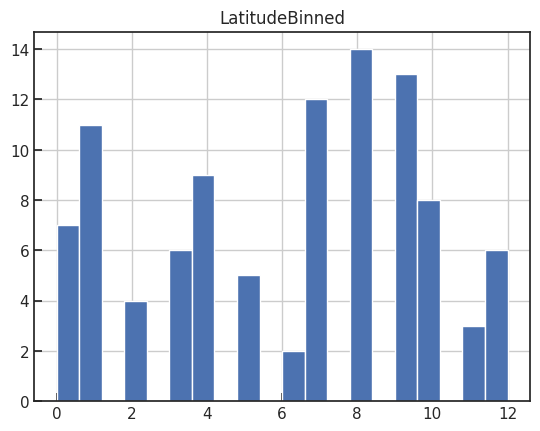

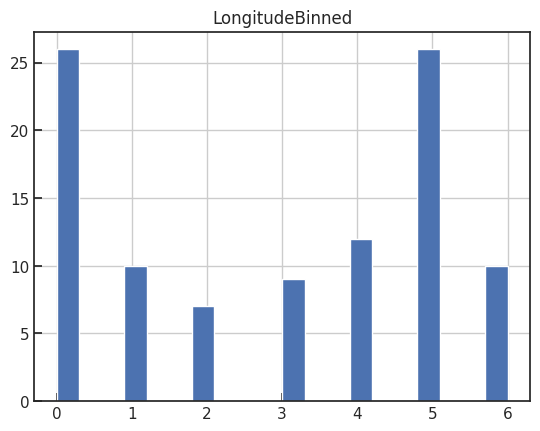

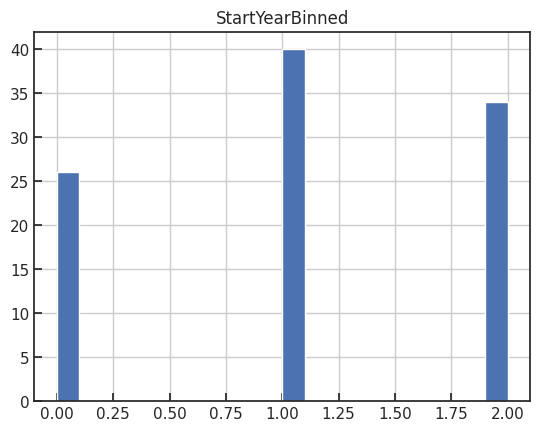

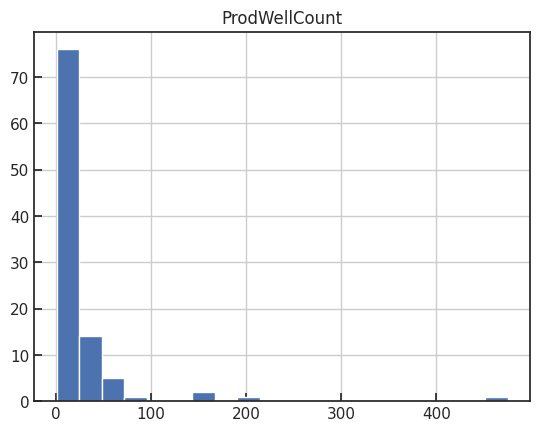

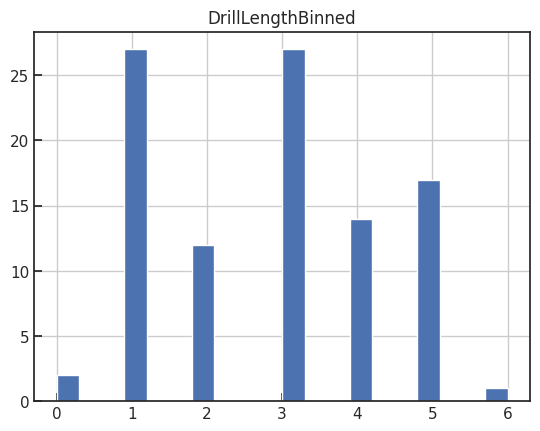

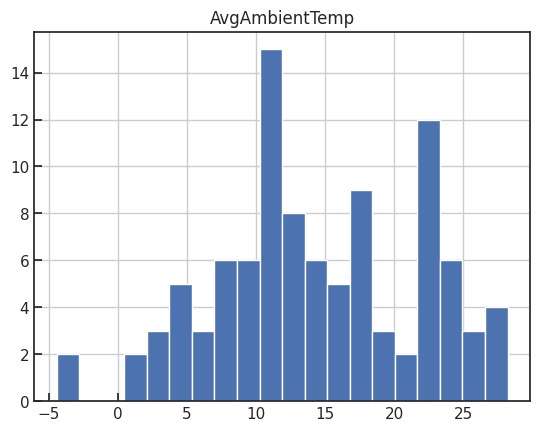

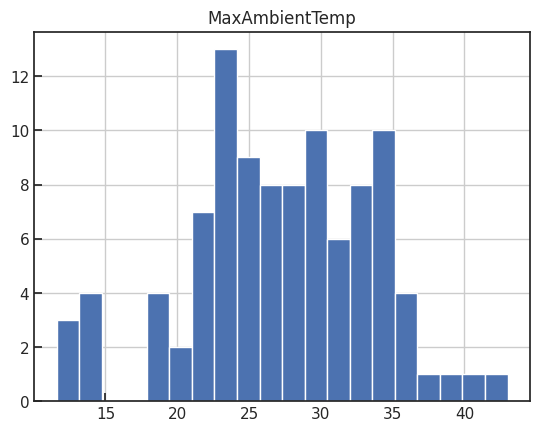

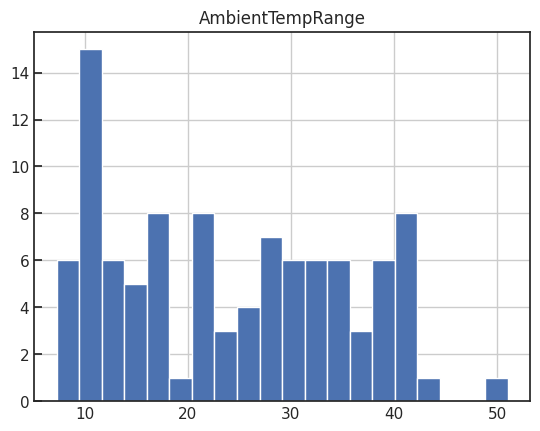

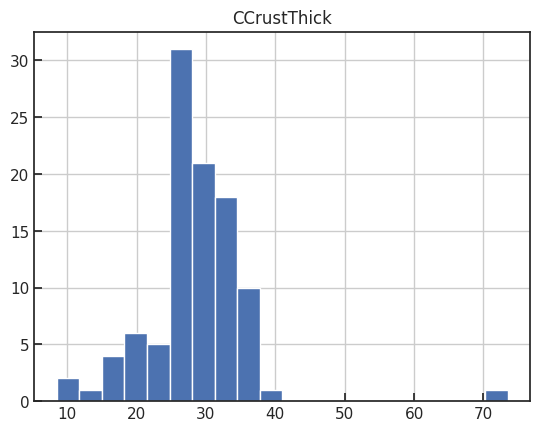

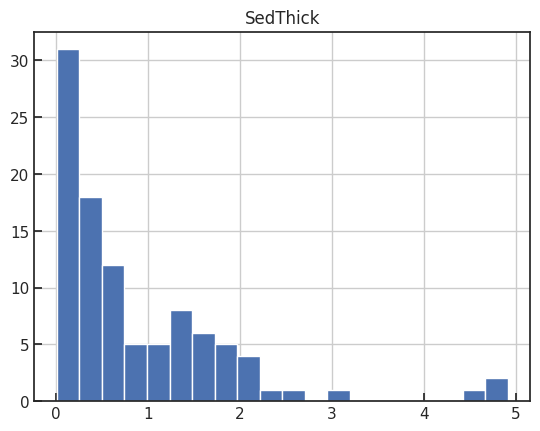

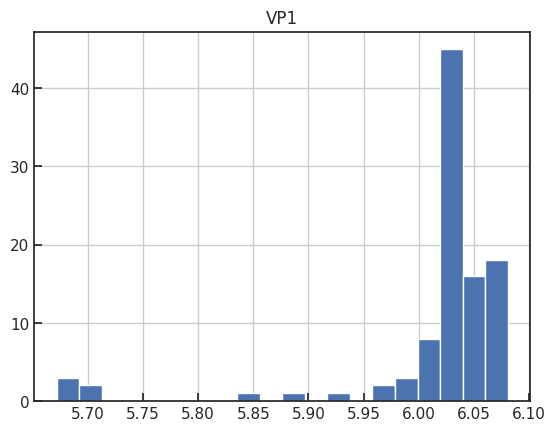

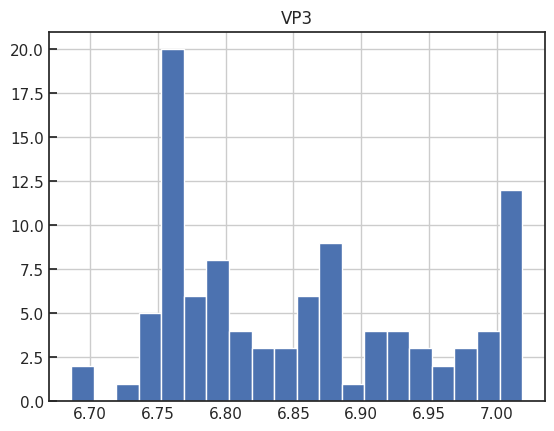

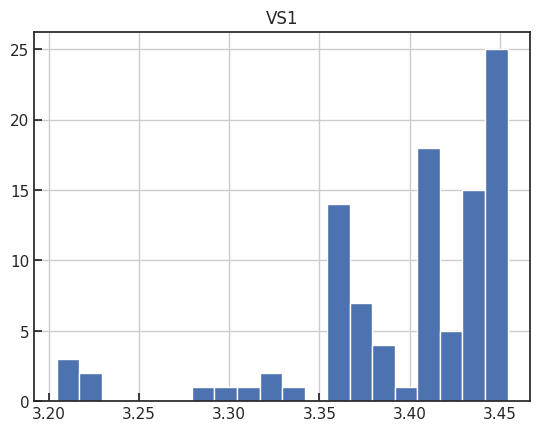

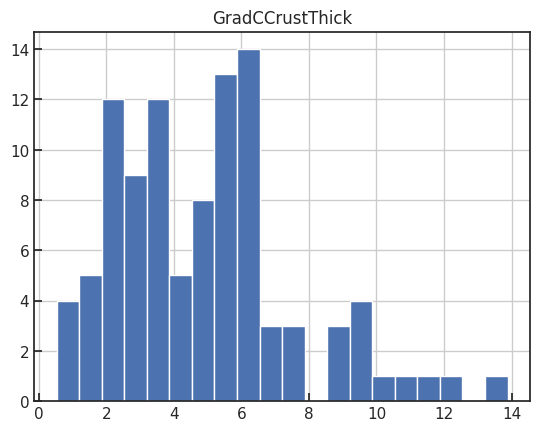

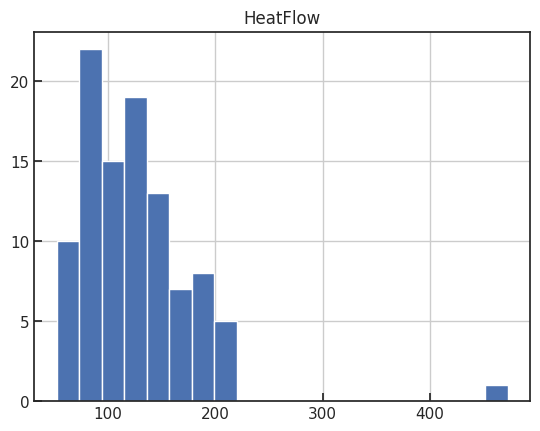

In [ ]:
# review histograms of all numerical variables
for c in numcols:
  datadf[c].hist(bins=20)
  plt.title(c)
  plt.show()

In [ ]:
# pairplot of unscaled data
import warnings
warnings.filterwarnings('ignore')
plotdf = datadf.drop(dropcols,axis=1)
print(plotdf.shape)

# this line takes a long time to run!
# fig = sns.pairplot(plotdf, height=4, corner=True, dropna=True)

(100, 36)
